In [68]:
!pip install --upgrade pip
!pip install pyathena

In [69]:
#Upgrade de la version de seaborn para poder hacer graficos mas facil 
!pip install seaborn==0.12.2

In [70]:
#Libraries
from pyathena import connect
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer 

In [71]:
# DB Setting
bucket_name = 's3://viamericas-datalake-dev-us-east-1-283731589572-athena/'
origin_name = 'AwsDataCatalog'
database_name = 'analytics'
tablaSource = 'source_fraud_fechas_label'


id_branch, id_receiver, hour_receiver, day_name_receiver, net_amount_receiver, id_payout, 
            receiver_transaction_count, id_country_receiver_claim,
            id_state, branch_working_days, sender_sending_days, sender_days_to_last_transaction, sender_minutes_since_last_transaction, branch_minutes_since_last_transaction, fraud_type,
            day, date_receiver, state_sender, date_receiver_clean, ptx_brancity, idlocation_fraud

In [216]:
#Connection
conn = connect(s3_staging_dir=f'{bucket_name}queryresults/',
               region_name='us-east-1')

#Pongo el mes para el que traigo los datos y para poenr en el nombre del parquet
mes_data = '202309' #812 secs
#Pongo uno si quiero generar los datos para el test
archivo_test = 1

df_source = pd.read_sql('''select abt.*
                        from (select * from analytics.abt_fraud
                            where date_receiver between cast('2023-09-01' as date) and cast('2023-10-01' as date)) abt inner join
                            (select id_receiver, id_branch, max(cast(day as timestamp)) last
                            from analytics.abt_fraud where date_receiver > cast(day as timestamp)
                            group by id_receiver, id_branch) ult_st
                        on abt.id_receiver = ult_st.id_receiver and abt.id_branch = ult_st.id_branch 
                        and cast(abt.day as timestamp) = ult_st.last;;''', conn)


/tmp/ipykernel_22674/3555101191.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_source = pd.read_sql('''select abt.*


In [217]:
#Traigo los percentiles que voy a usar en la normalizacion de algunas variables 130 sec
df_perc1 = pd.read_sql('''select 'receiver_transaction_count', ptile, min(receiver_transaction_count), max(receiver_transaction_count)
from (select NTILE(100) OVER (order by receiver_transaction_count) as ptile, receiver_transaction_count
    from analytics.abt_fraud
    where date_receiver between cast('2023-01-01' as timestamp) and cast('2023-08-01' as timestamp))
where ptile = 1 or ptile = 99
group by ptile
union 
select 'sender_sending_days', ptile, min(sender_sending_days), max(sender_sending_days)
from (select NTILE(100) OVER (order by sender_sending_days) as ptile, sender_sending_days
    from analytics.abt_fraud
    where date_receiver between cast('2023-01-01' as timestamp) and cast('2023-08-01' as timestamp))
where ptile = 1 or ptile = 99
group by ptile
union
select 'branch_working_days', ptile, min(branch_working_days), max(branch_working_days)
from (select NTILE(100) OVER (order by branch_working_days) as ptile, branch_working_days
    from analytics.abt_fraud
    where date_receiver between cast('2023-01-01' as timestamp) and cast('2023-08-01' as timestamp))
where ptile = 1 or ptile = 99
group by ptile
union
select 'net_amount_receiver', ptile, min(net_amount_receiver), max(net_amount_receiver)
from (select NTILE(100) OVER (order by net_amount_receiver) as ptile, net_amount_receiver
    from analytics.abt_fraud
    where date_receiver between cast('2023-01-01' as timestamp) and cast('2023-08-01' as timestamp))
where ptile = 1 or ptile = 99
group by ptile;''',conn)

df_perc2 = pd.read_sql('''select 'branch_trans_3m', ptile, min(branch_trans_3m), max(branch_trans_3m)
from (select NTILE(100) OVER (order by branch_trans_3m) as ptile, branch_trans_3m
    from analytics.abt_fraud
    where date_receiver between cast('2023-01-01' as timestamp) and cast('2023-08-01' as timestamp))
where ptile = 1 or ptile = 99
group by ptile
union
select 'branch_trans_40min', ptile, min(branch_trans_40min), max(branch_trans_40min)
from (select NTILE(100) OVER (order by branch_trans_40min) as ptile, branch_trans_40min
    from analytics.abt_fraud
    where date_receiver between cast('2023-01-01' as timestamp) and cast('2023-08-01' as timestamp))
where ptile = 1 or ptile = 99
group by ptile
union
select 'branch_trans_10min', ptile, min(branch_trans_10min), max(branch_trans_10min)
from (select NTILE(100) OVER (order by branch_trans_10min) as ptile, branch_trans_10min
    from analytics.abt_fraud
    where date_receiver between cast('2023-01-01' as timestamp) and cast('2023-08-01' as timestamp))
where ptile = 1 or ptile = 99
group by ptile
union
select 'cash_pick_up_4min', ptile, min(cash_pick_up_4min), max(cash_pick_up_4min)
from (select NTILE(100) OVER (order by cash_pick_up_4min) as ptile, cash_pick_up_4min
    from analytics.abt_fraud
    where date_receiver between cast('2023-01-01' as timestamp) and cast('2023-08-01' as timestamp))
where ptile = 1 or ptile = 99
group by ptile
union
select 'sender_trans_3m', ptile, min(sender_trans_3m), max(sender_trans_3m)
from (select NTILE(100) OVER (order by sender_trans_3m) as ptile, sender_trans_3m
    from analytics.abt_fraud
    where date_receiver between cast('2023-01-01' as timestamp) and cast('2023-08-01' as timestamp))
where ptile = 1 or ptile = 99
group by ptile;''',conn)

/tmp/ipykernel_22674/2287332812.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_perc1 = pd.read_sql('''select 'receiver_transaction_count', ptile, min(receiver_transaction_count), max(receiver_transaction_count)
/tmp/ipykernel_22674/2287332812.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_perc2 = pd.read_sql('''select 'branch_trans_3m', ptile, min(branch_trans_3m), max(branch_trans_3m)


In [218]:
df_source.head()

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,id_payout,status,was_fraud,...,branch_has_fraud,fecha_last_fraud_branch,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_4min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud
0,A23853,1432,2023-09-17 17:20:06.400,KY0100,T232,9266646,900.0000,C,Cancelled,0,...,0,NaT,0,2,1,0,0,5,560.0000,0
1,A23005,1233,2023-09-16 16:00:36.693,CT0159,T060,8871093,250.0000,P,Paid,0,...,0,NaT,0,1,1,1,0,7,398.8729,0
2,A21843,20547,2023-09-04 13:16:25.883,VA0936,T232,9263548,118.0000,P,Paid,0,...,0,NaT,0,4,1,1,0,1,118.0000,0
3,A15418,35916,2023-09-01 11:54:32.850,FL1808,T232,10613633,502.0000,P,Paid,0,...,0,NaT,0,1,1,1,0,1,502.0000,0
4,A23916,32972,2023-09-17 18:26:27.363,FL2272,T228,9886701,1000.0000,P,Paid,0,...,0,NaT,0,34,9,6,0,7,678.5714,0


In [219]:
df_source['mes'] = df_source['date_receiver'].dt.month
df_source['fraud_type'] = df_source['fraud_type'].str.capitalize()

In [220]:
## Traigo precentiles para normalizar

In [221]:
df_perc = pd.concat([df_perc1, df_perc2], ignore_index=True)
df_perc = df_perc.rename(columns={"_col0": "Variable", "_col2": "Min", "_col3": "Max", "_col4": "Avg"})
df_perc

,Variable,ptile,Min,Max
0,sender_sending_days,99,76,88
1,receiver_transaction_count,99,9,90
2,receiver_transaction_count,1,1,1
3,net_amount_receiver,99,93.0000,980.0000
4,sender_sending_days,1,0,0
5,net_amount_receiver,1,.0000,100.0000
6,branch_working_days,99,961,981
7,branch_working_days,1,-1,1014
8,branch_trans_10min,99,7,8
9,branch_trans_40min,99,19,24


## Defino funciones para los datos
### creo_dummies y escalo_percentiles

In [222]:
#defino funcion para normalizar
def escalo_percentiles(data, Pmin, Pmax, calculo):
    #Escalo por Quartiles
    
    m = data.min()
    M = data.max()
    if calculo==1:
        Qmin = Pmin
        Qmax = Pmax
        q0 = data.quantile(Qmin)
        q1 = data.quantile(Qmax)
    elif calculo==0:
            q0=Pmin
            q1=Pmax
    data_std = (data - q0) / (q1 - q0)
    dataN =  data_std.to_numpy()
    #Pongo los outliers con un maximo
    dataN = np.clip(dataN,0,1)
    return dataN

In [223]:
#creo dummies a partir de la lista de variables
def creo_dummies(df, todummy_list):
    df0 = df.copy()
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, axis = 1)
        df = pd.concat([df, dummies], axis=1)
        df = pd.DataFrame(df)
    return df, df.columns.difference(df0.columns)

## Creo las nuevas variables
### 01_isMexico y 01_sender_branch_state
### 01_isCashPick y 01_isBankDep 
### sender_days_to_last_transaction_365 y sender_days_to_last_transaction_more365
### sender_days_to_last_transaction_7m y sender_days_to_last_transaction_more7m
### sender_minutes_since_last_transaction_2days y sender_minutes_since_last_transaction_1day


In [224]:
df_source['hour_receiver'] = df_source['date_receiver'].dt.hour
df_source['day_name_receiver'] = df_source['date_receiver'].dt.weekday

In [225]:
df_source['01_isMexico'] = (df_source['id_country_receiver_claim'].str.strip() =='MEX')
df_source['01_sender_branch_state'] = (df_source['sender_state'].str.strip() == df_source['id_state'].str.strip())
df_source['01_Var_range_hist'] = df_source['net_amount_receiver'].astype(float) / df_source['range_hist']
df_source['01_receiver_fraud'] = (df_source['receiver_has_fraud']>0)
df_source['01_branch_fraud'] = (df_source['branch_has_fraud']>0)
df_source['01_location_fraud'] = (df_source['location_nro_fraud']>0)
df_source['01_sender_fraud'] = (df_source['sender_nro_fraud']>0)

#df_source[['01_Var_range_hist','net_amount_receiver','range_hist']]

In [226]:
cash_payout = ['M','P','S']
bankdp_payout =['C','N','X','T']

df_source['01_isCashPick'] = df_source.id_payout.isin(cash_payout)
df_source['01_isBankDep'] = df_source.id_payout.isin(bankdp_payout)
#df_source[['01_isCashPick','id_payout','01_isBankDep']]

In [227]:
# Ver si la puedo agregar
#df_source['branch_prom_diario'] = 

In [228]:
#defino corte al año
df_source.loc[:,'sender_days_to_last_transaction_365'] = df_source['sender_days_to_last_transaction'].astype(float)
df_source.loc[:,'sender_days_to_last_transaction_more365'] = 0
df_source.loc[df_source['sender_days_to_last_transaction'].astype(float)> 365, 'sender_days_to_last_transaction_more365'] = 1
df_source.loc[df_source['sender_days_to_last_transaction'].astype(float)> 365, 'sender_days_to_last_transaction_365'] = 0 

#Hago otro corte a 7 meses
df_source.loc[:,'sender_days_to_last_transaction_7m'] = df_source['sender_days_to_last_transaction'].astype(float)
df_source.loc[:,'sender_days_to_last_transaction_more7m'] = 0
df_source.loc[df_source['sender_days_to_last_transaction'].astype(float)> 7*30, 'sender_days_to_last_transaction_more7m'] = 1
df_source.loc[df_source['sender_days_to_last_transaction'].astype(float)> 7*30, 'sender_days_to_last_transaction_7m'] = 0 

In [229]:
#minutos a ultima transaccion para uno y dos dias
df_source.loc[:, 'sender_minutes_since_last_transaction_2days'] = df_source['sender_minutes_since_last_transaction'].astype(float)
df_source.loc[:, 'sender_minutes_since_last_transaction_1day'] = df_source['sender_minutes_since_last_transaction'].astype(float)

df_source.loc[df_source['sender_minutes_since_last_transaction'].astype(float)> 2*24*60, 'sender_minutes_since_last_transaction_2days'] = 0
df_source.loc[df_source['sender_minutes_since_last_transaction'].astype(float)> 24*60, 'sender_minutes_since_last_transaction_1day'] = 0

## Estandarizo variables
### sender_days_to_last_transaction_365, sender_minutes_since_last_transaction_2days, net_amount_receiver, sender_sending_days, branch_working_days, receiver_transaction_count

In [230]:
#Varibles nuevas creadas
df_source['branch_trans_3m']
df_source['sender_trans_3m']

df_source['location_nro_fraud']
df_source['branch_has_fraud']
df_source['sender_nro_fraud']
df_source['branch_trans_40min']
df_source['branch_trans_10min']
df_source['receiver_transaction_count']
df_source['sender_sending_days']
df_source['branch_working_days']
df_source['net_amount_receiver']


0           900.0000
1           250.0000
2           118.0000
3           502.0000
4          1000.0000
             ...    
2420746     650.0000
2420747     700.0000
2420748      95.0000
2420749    1300.0000
2420750     100.0000
Name: net_amount_receiver, Length: 2420751, dtype: object

In [231]:
float(Mx)

24.0

In [232]:
Mx = df_perc.Max[(df_perc['Variable']=='receiver_transaction_count') & (df_perc['ptile']==99)].item()
mn = df_perc.Min[(df_perc['Variable']=='receiver_transaction_count') & (df_perc['ptile']==1)].item()
Mx = int(Mx)
mn = int(mn)

df_source['01_receiver_transaction_count'] = escalo_percentiles(df_source['receiver_transaction_count'].astype(int), mn, Mx, 0)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='01_receiver_transaction_count', ylabel='Count'>

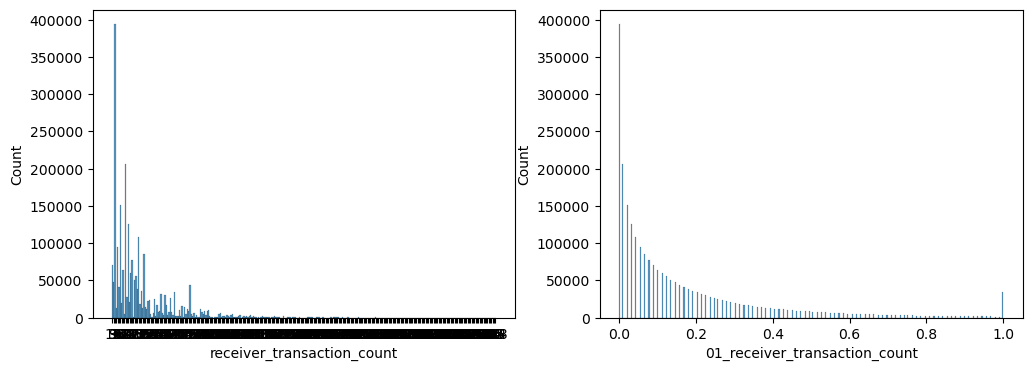

In [233]:
fig, axs = plt.subplots(1,2,figsize = (12, 4))
sns.histplot(data=df_source, x="receiver_transaction_count", ax = axs[0])
sns.histplot(data=df_source, x="01_receiver_transaction_count", ax = axs[1])

In [234]:
Mx = df_perc.Max[(df_perc['Variable']=='sender_sending_days') & (df_perc['ptile']==99)].item()
mn = df_perc.Min[(df_perc['Variable']=='sender_sending_days') & (df_perc['ptile']==1)].item()
Mx = int(Mx)
mn = int(mn)

df_source['01_sender_sending_days'] = escalo_percentiles(df_source['sender_sending_days'].astype(int), mn, Mx, 0)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='01_sender_sending_days', ylabel='Count'>

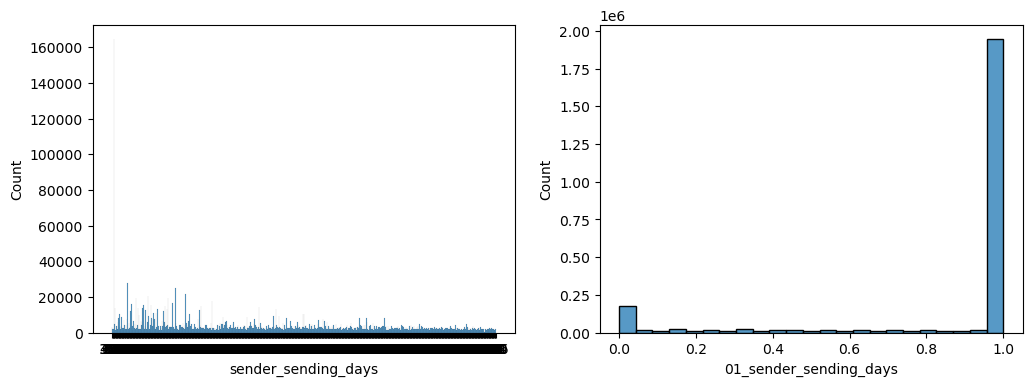

In [235]:
fig, axs = plt.subplots(1,2,figsize = (12, 4))
sns.histplot(data=df_source, x="sender_sending_days", ax = axs[0])
sns.histplot(data=df_source, x="01_sender_sending_days", ax = axs[1])

In [236]:
# Normalizo a lo bruto. Dsp reviso el algoritmo
Mx = df_perc.Max[(df_perc['Variable']=='receiver_transaction_count') & (df_perc['ptile']==99)].item()
mn = df_perc.Min[(df_perc['Variable']=='receiver_transaction_count') & (df_perc['ptile']==1)].item()
Mx = int(Mx)
mn = int(mn)

df_source['01_receiver_transaction_count'] = escalo_percentiles(df_source['receiver_transaction_count'].astype(int), mn, Mx, 0)

Mx = df_perc.Max[(df_perc['Variable']=='branch_working_days') & (df_perc['ptile']==99)].item()
mn = df_perc.Min[(df_perc['Variable']=='branch_working_days') & (df_perc['ptile']==1)].item()
Mx = int(Mx)
mn = int(mn)

df_source['01_branch_working_days'] = escalo_percentiles(df_source['branch_working_days'].astype(int), mn, Mx, 0)

Mx = df_perc.Max[(df_perc['Variable']=='net_amount_receiver') & (df_perc['ptile']==99)].item()
mn = df_perc.Min[(df_perc['Variable']=='net_amount_receiver') & (df_perc['ptile']==1)].item()
Mx = float(Mx)
mn = float(mn)

df_source['01_net_amount_receiver'] = escalo_percentiles(df_source['net_amount_receiver'].astype(float), mn, Mx, 0)

Mx = 2880
mn = 0
df_source['01_sender_minutes_since_last_transaction_2days'] = escalo_percentiles(df_source['sender_minutes_since_last_transaction_2days'], mn, Mx, 0)

Mx = 1440
mn = 0
df_source['01_sender_minutes_since_last_transaction_1day'] = escalo_percentiles(df_source['sender_minutes_since_last_transaction_1day'], mn, Mx, 0)

Mx = 365
mn = 0
df_source['01_sender_days_to_last_transaction_365'] = escalo_percentiles(df_source['sender_days_to_last_transaction_365'], mn, Mx, 0)

Mx = 7*30
mn = 0
df_source['01_sender_days_to_last_transaction_7m'] = escalo_percentiles(df_source['sender_days_to_last_transaction_7m'], mn, Mx, 0)

In [237]:
#Agregadas
Mx = 24
mn = 0
df_source['01_hour_receiver'] = escalo_percentiles(df_source['hour_receiver'], mn, Mx, 0)

In [238]:
#df_source['01_receiver_transaction_count'].describe()
#df_source['01_sender_sending_days'].describe()
#df_source['01_branch_working_days'].describe()
#df_source['01_net_amount_receiver'].describe()
#df_source['01_sender_minutes_since_last_transaction_2days'].describe()
#df_source['01_sender_minutes_since_last_transaction_1day'].describe()
#df_source['01_sender_days_to_last_transaction_365'].describe()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='01_sender_days_to_last_transaction_365', ylabel='Count'>

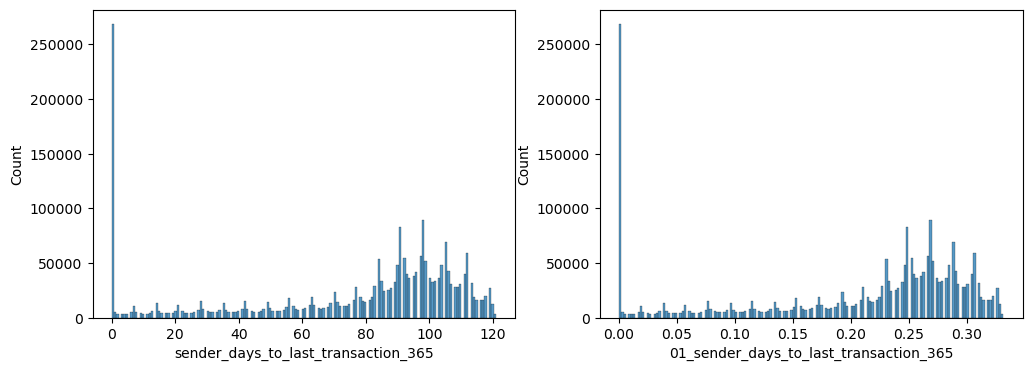

In [239]:
fig, axs = plt.subplots(1,2,figsize = (12, 4))
sns.histplot(data=df_source, x="sender_days_to_last_transaction_365", ax = axs[0])
sns.histplot(data=df_source, x="01_sender_days_to_last_transaction_365", ax = axs[1])

## Creo Variables dummy

In [240]:
todummy_list = ['day_name_receiver','id_payout']
[df_source, var_nuevas] = creo_dummies(df_source, todummy_list)

## Creacion del target

In [241]:
df_source['fraud_type'].value_counts()

fraud_type
Payment          67
Remote access     8
Name: count, dtype: int64

In [242]:
# defino los targets
df_source['targetR'] = df_source['fraud_type'] == 'Remote access'
df_source['targetP'] = df_source['fraud_type'] == 'Payment'
df_source['target_fraudes'] = df_source['fraud_type'].notnull()


In [243]:
df_source['targetR'].value_counts()

targetR
False    2420743
True           8
Name: count, dtype: int64

In [244]:
df_source['targetP'].value_counts()

targetP
False    2420684
True          67
Name: count, dtype: int64

In [245]:
df_source['target_fraudes'].value_counts()

target_fraudes
False    2420676
True          75
Name: count, dtype: int64

In [246]:
df_source.columns.values

array(['id_branch', 'id_receiver', 'date_receiver', 'id_location',
       'id_payer', 'id_sender_global', 'net_amount_receiver', 'status',
       'was_fraud', 'receiver_transaction_count',
       'receiver_date_first_transaction',
       'receiver_date_last_transaction', 'id_country_receiver_claim',
       'id_state_receiver_claim', 'id_state', 'branch_working_days',
       'sender_sending_days', 'sender_days_to_last_transaction',
       'id_country', 'fraud_classification',
       'sender_minutes_since_last_transaction',
       'sender_days_since_last_transaction', 'fraud_type',
       'fraud_classification_2', 'incident_code', 'id_country_receiver',
       'id_payment', 'id_state_receiver', 'id_city_receiver',
       'bank_receiver', 'branch_trans_3m', 'count_date_receiver_distinct',
       'sender_state', 'day', 'branch_has_fraud',
       'fecha_last_fraud_branch', 'receiver_has_fraud',
       'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_4min',
       'location_nro_frau

## Guardo archivos para dsp juntar en el entrenamiento

In [247]:
#Me quedo con las variables q voy a usar
df_source.columns.values
df = df_source.drop(columns=[ 'fraud_type','fraud_classification_2', 'incident_code', 'id_country_receiver',
       'id_payment', 'id_state_receiver', 'id_city_receiver', 'bank_receiver','status','was_fraud','day',
        'targetR','targetP','target_fraudes'])

#df = pd.concat([df, df_source[var_nuevas]], axis=1)
df = pd.concat([df, df_source[['targetR','targetP','target_fraudes']]], axis=1)


In [248]:
import os
import pyarrow as pa
import pyarrow.parquet as pq

In [249]:
if archivo_test == 0:
    s3_url = f"s3://viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Train/Preproc_Fr_{mes_data}.parquet"
elif archivo_test ==1:
    s3_url = f"s3://viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Test/Preproc_Fr_{mes_data}.parquet"
#df.to_parquet(path='./exp1.parquet', engine='pyarrow', compression='gzip')
df.to_parquet(path=s3_url, engine='pyarrow', compression='gzip')
print('termine de salvar el parquet')

termine de salvar el parquet


In [250]:
df.head(5)

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,receiver_transaction_count,receiver_date_first_transaction,receiver_date_last_transaction,...,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target_fraudes
0,A23853,1432,2023-09-17 17:20:06.400,KY0100,T232,9266646,900.0000,9,2022-12-04 18:29:38.597000000,2023-11-04 17:54:07.387000000,...,False,False,False,False,False,False,False,False,False,False
1,A23005,1233,2023-09-16 16:00:36.693,CT0159,T060,8871093,250.0000,14,2022-10-31 18:40:39.057000000,2023-12-17 15:39:15.420000000,...,False,False,False,True,False,False,False,False,False,False
2,A21843,20547,2023-09-04 13:16:25.883,VA0936,T232,9263548,118.0000,1,2023-09-04 13:16:25.883000000,2023-09-04 13:16:25.883000000,...,False,False,False,True,False,False,False,False,False,False
3,A15418,35916,2023-09-01 11:54:32.850,FL1808,T232,10613633,502.0000,1,2023-09-01 11:54:32.850000000,2023-09-01 11:54:32.850000000,...,False,False,False,True,False,False,False,False,False,False
4,A23916,32972,2023-09-17 18:26:27.363,FL2272,T228,9886701,1000.0000,14,2023-04-02 14:57:03.837000000,2023-12-10 12:34:02.967000000,...,False,False,False,True,False,False,False,False,False,False


In [251]:
mes_data

'202309'